# Example of the Basic HMM Approach

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import sys

# Configure plotting
import matplotlib.pyplot as plt
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

In [10]:
# Add hidden_regime to path

sys.path.insert(0, '../')
from hidden_regime.data.loader import DataLoader
from hidden_regime.config.settings import DataConfig
from hidden_regime.models.config import HMMConfig
from hidden_regime.models.base_hmm import HiddenMarkovModel
from hidden_regime.models.state_standardizer import StateStandardizer

## Data Collection

In [97]:
TICKER = 'DOGE-USD'
NUM_STATES = 5
REGIME_TYPE = f'{NUM_STATES}_state'
START_DATE = '2020-01-01'
END_DATE = '2020-12-31'
FUTURE_DATE = '2021-02-01'
RANDOM_SEED = 4242
DATE_FMT = '%Y-%m-%d'

In [98]:
config = DataConfig(cache_enabled=True, include_volume=True)
loader = DataLoader(config=config)

In [99]:
end_date =  datetime.strptime(END_DATE, DATE_FMT)
start_date = end_date - timedelta(days=730)  # 2 years of data

data = loader.load_stock_data(
    ticker=TICKER,
    start_date=start_date,
    end_date=end_date
)

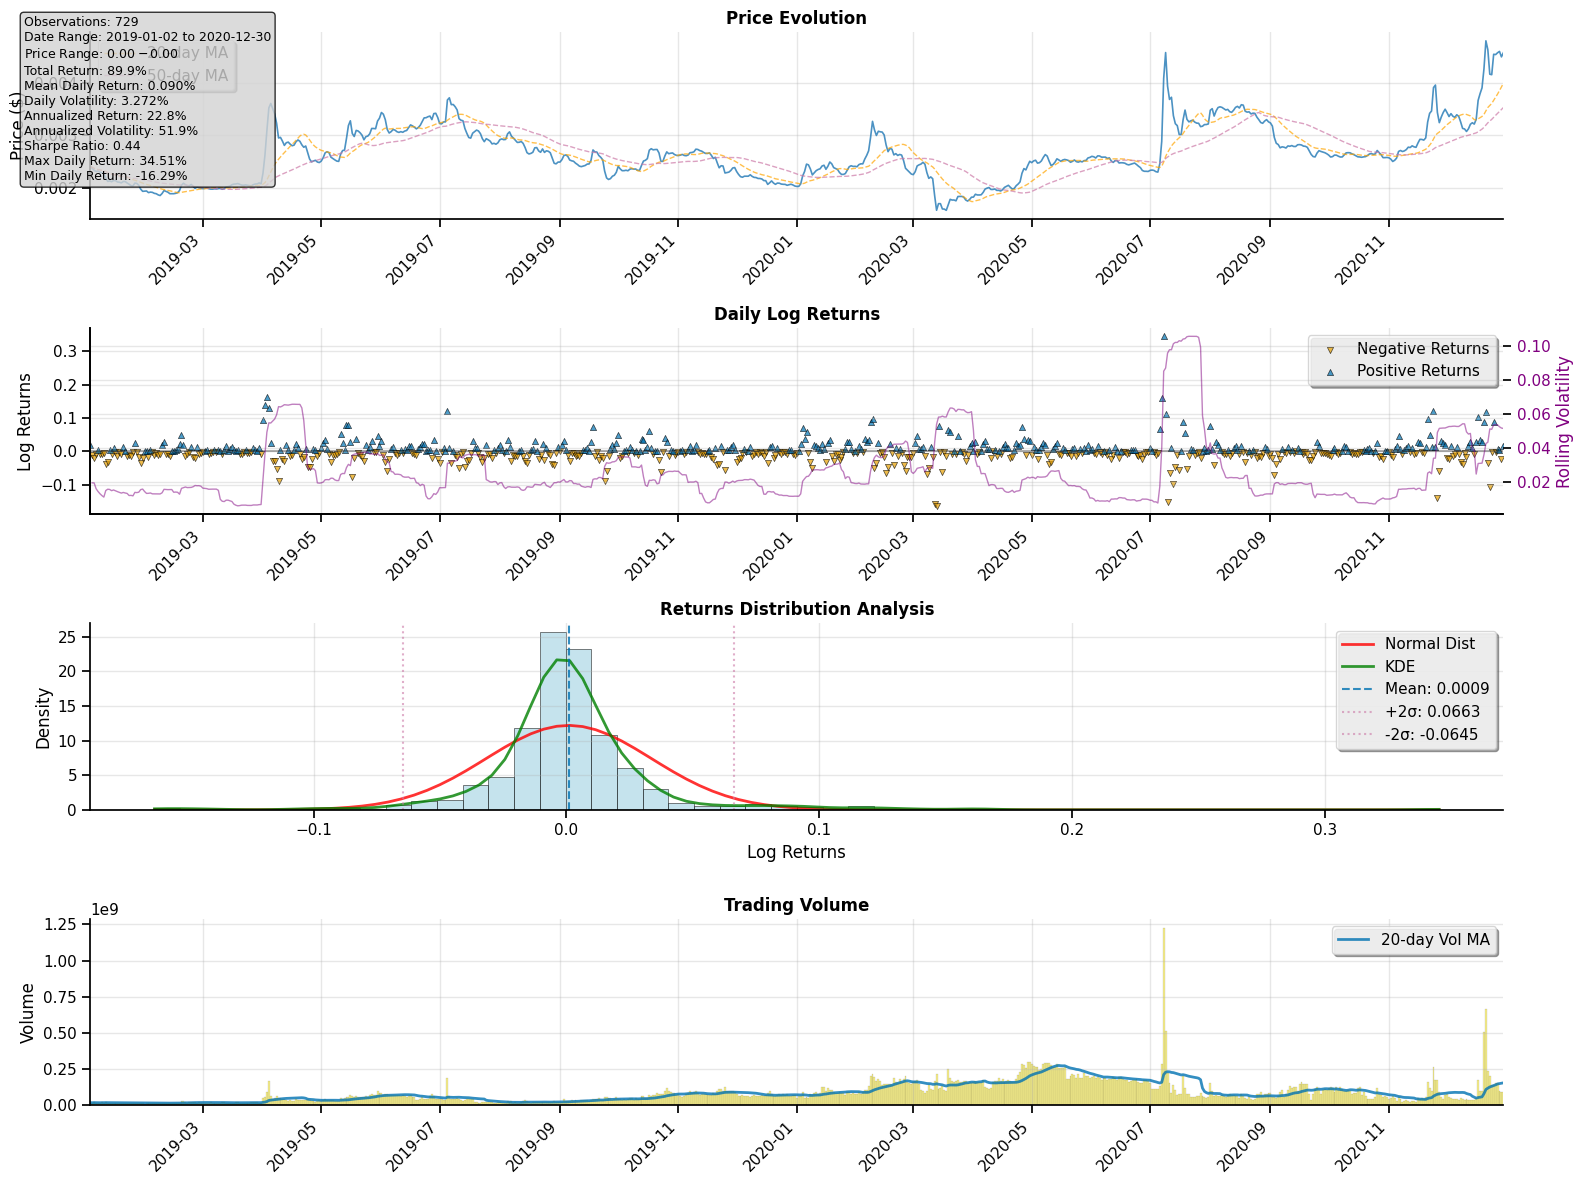

In [100]:
fig = loader.plot(data, plot_type='all', figsize=(16, 12))

In [101]:
returns = data['log_return'].values
dates = data['date'].values

In [102]:
hmm_config = HMMConfig.for_standardized_regimes(regime_type=REGIME_TYPE, conservative=False)

In [103]:
hmm = HiddenMarkovModel(config=hmm_config)
hmm.fit(returns, verbose=True)

Training 5-state HMM on 729 observations
Max iterations: 100, Tolerance: 1e-06
Iteration 0: Log-likelihood = 1749.1165, Improvement = inf
Iteration 10: Log-likelihood = 1779.7834, Improvement = 0.548226
Iteration 20: Log-likelihood = 1784.3251, Improvement = 0.467904
Iteration 30: Log-likelihood = 1787.9315, Improvement = 0.206222
Iteration 40: Log-likelihood = 1789.7955, Improvement = 0.328649
Iteration 50: Log-likelihood = 1793.4412, Improvement = 0.299422
Iteration 60: Log-likelihood = 1795.0994, Improvement = 0.093458
Iteration 70: Log-likelihood = 1795.6137, Improvement = 0.027555
Iteration 80: Log-likelihood = 1795.7595, Improvement = 0.007727
Iteration 90: Log-likelihood = 1795.8014, Improvement = 0.002305
Applied state standardization and ordering
Regime validation confidence: 0.899
Training completed in 55.53s
Final log-likelihood: 1795.8136


/mnt/c/Workspace/hidden-regime/notebooks/../hidden_regime/models/base_hmm.py:267: UserWarning: HMM did not converge after 100 iterations. Final improvement: 0.000828
  warnings.warn(


HiddenMarkovModel(n_states=5, fitted=True, log_likelihood=1795.81)

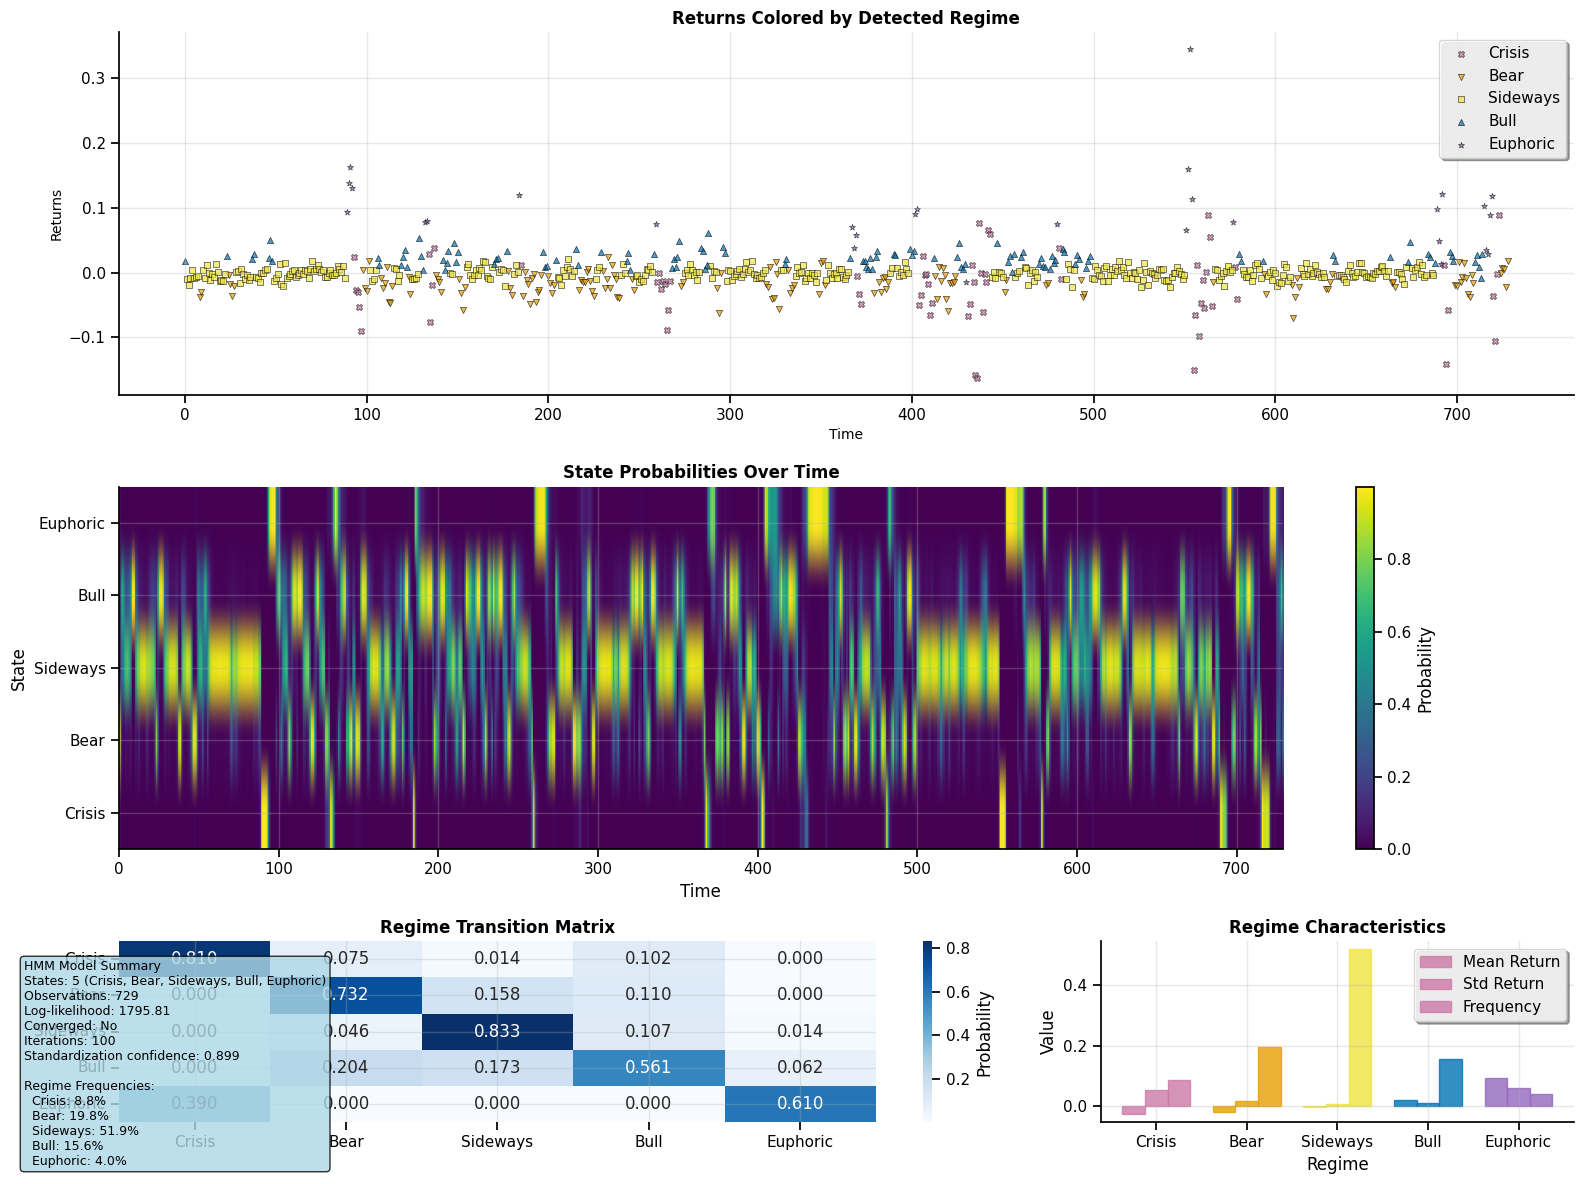

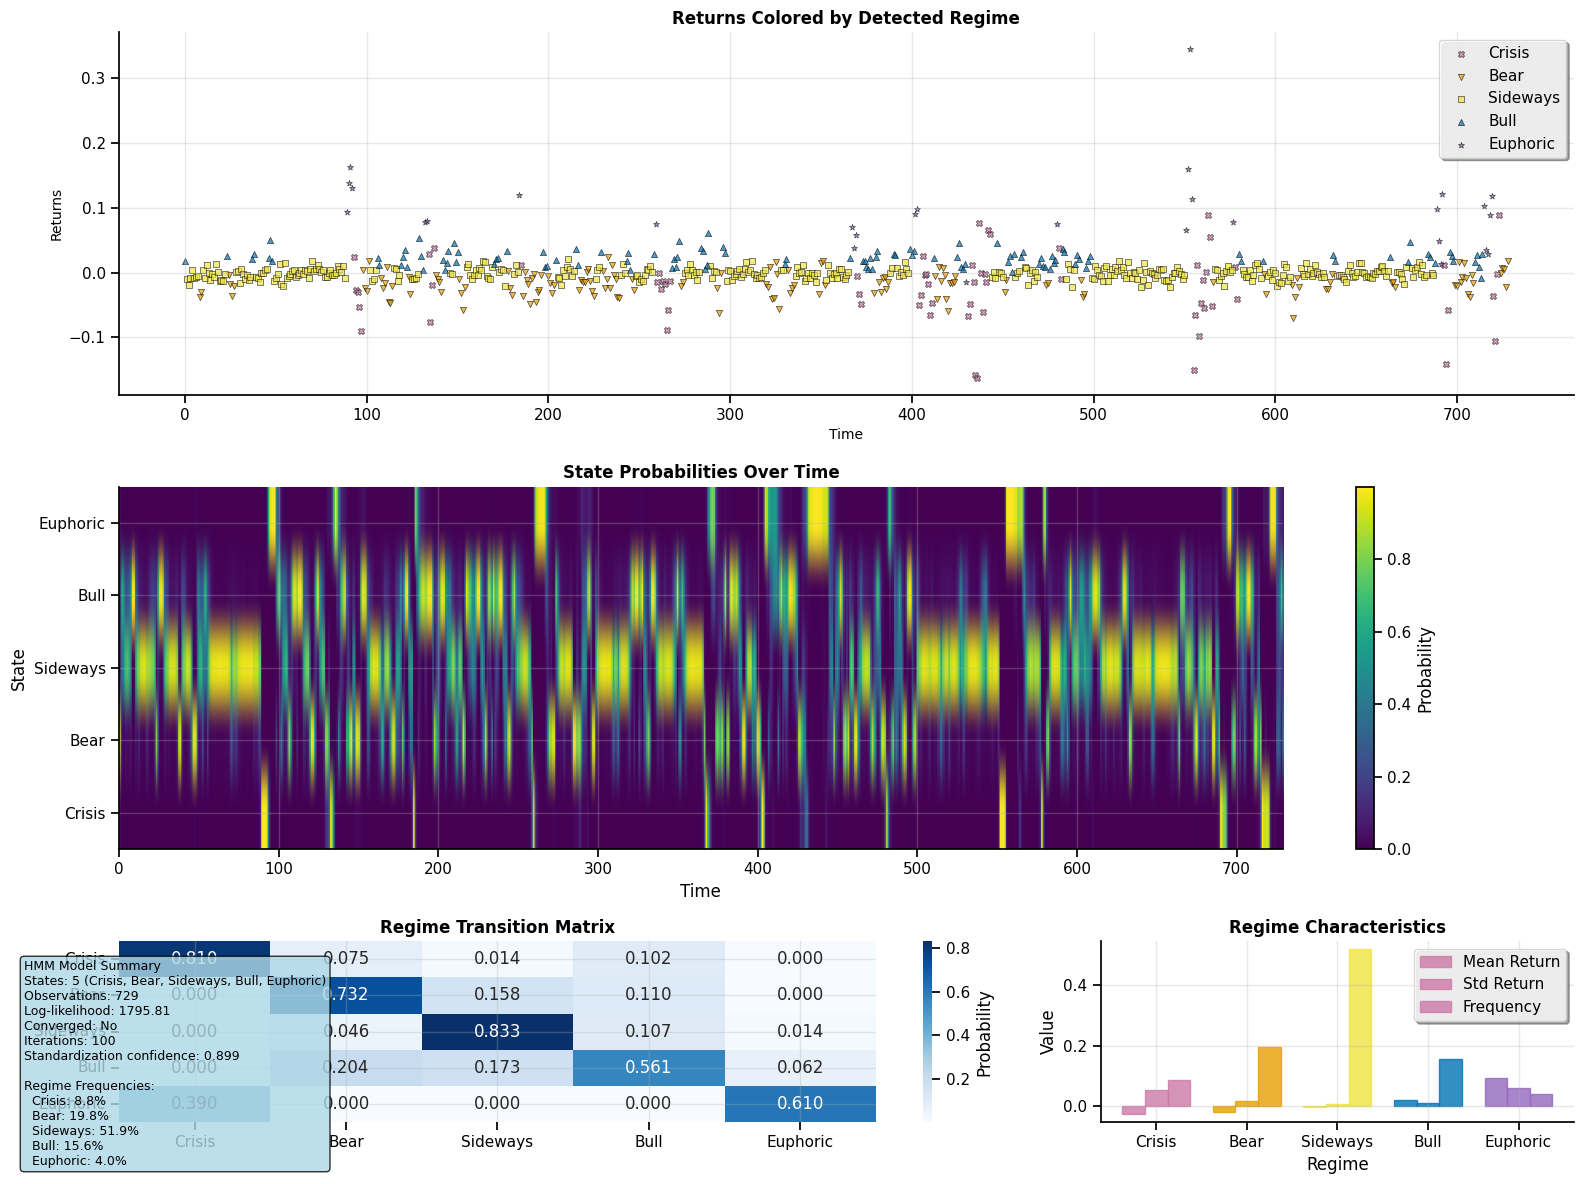

In [104]:
hmm.plot(returns)

In [105]:
last_price = data['price'].iloc[-1]
last_date = data['date'].iloc[-1]
print(f'On [{last_date.strftime(DATE_FMT)}] the price for {TICKER} was ${last_price:.3f}')

On [2020-12-30] the price for DOGE-USD was $0.005


In [106]:
standardizer = StateStandardizer(regime_type=REGIME_TYPE)
state_mapping = standardizer.standardize_states(hmm.emission_params_)
regime_names = [state_mapping[state] for state in range(NUM_STATES)]

In [107]:
future_end_date = datetime.strptime(FUTURE_DATE, DATE_FMT)
future_looking_data = loader.load_stock_data(
    ticker=TICKER,
    start_date=end_date,# - timedelta(days=2),
    end_date=future_end_date
)

In [108]:
predictions = pd.DataFrame(index=future_looking_data['date'], 
                        data=hmm.predict_proba(future_looking_data['log_return']),
                        columns=standardizer.current_config.state_names)

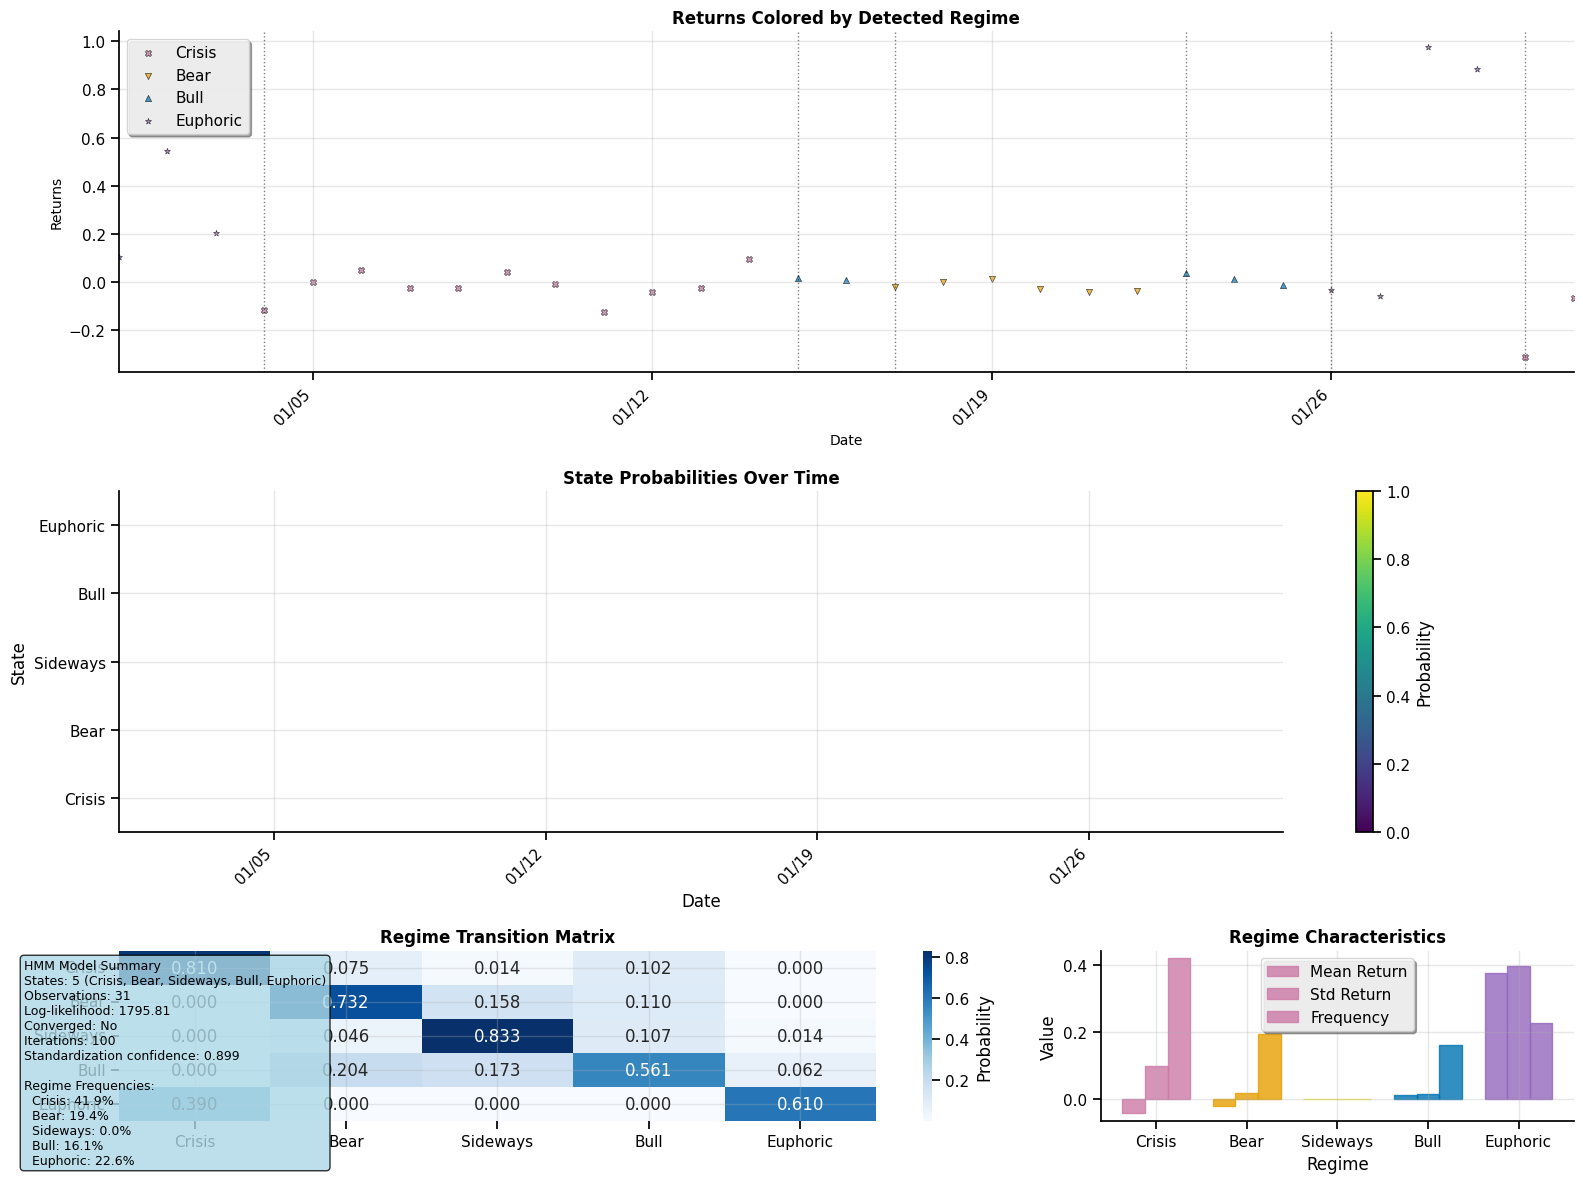

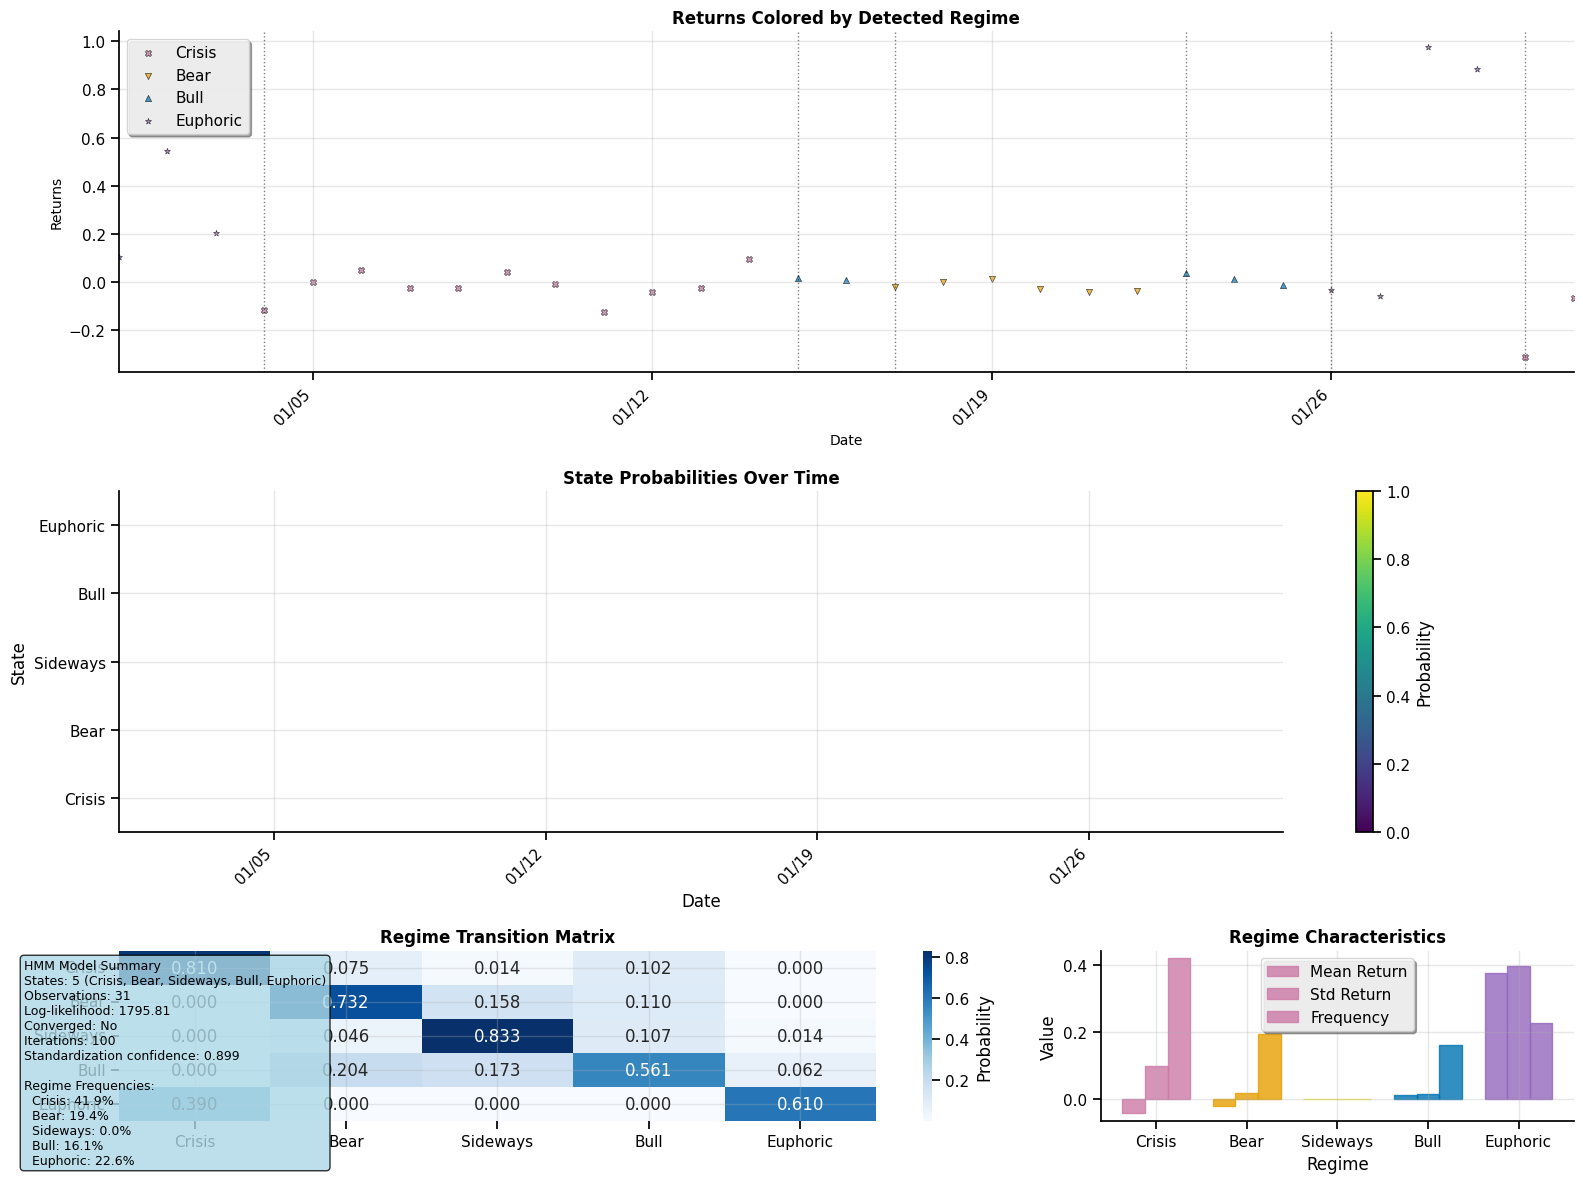

In [109]:
hmm.plot(returns=future_looking_data['log_return'], dates=future_looking_data['date'])

In [110]:
future_looking_data['date']

0    2021-01-01 00:00:00+00:00
1    2021-01-02 00:00:00+00:00
2    2021-01-03 00:00:00+00:00
3    2021-01-04 00:00:00+00:00
4    2021-01-05 00:00:00+00:00
5    2021-01-06 00:00:00+00:00
6    2021-01-07 00:00:00+00:00
7    2021-01-08 00:00:00+00:00
8    2021-01-09 00:00:00+00:00
9    2021-01-10 00:00:00+00:00
10   2021-01-11 00:00:00+00:00
11   2021-01-12 00:00:00+00:00
12   2021-01-13 00:00:00+00:00
13   2021-01-14 00:00:00+00:00
14   2021-01-15 00:00:00+00:00
15   2021-01-16 00:00:00+00:00
16   2021-01-17 00:00:00+00:00
17   2021-01-18 00:00:00+00:00
18   2021-01-19 00:00:00+00:00
19   2021-01-20 00:00:00+00:00
20   2021-01-21 00:00:00+00:00
21   2021-01-22 00:00:00+00:00
22   2021-01-23 00:00:00+00:00
23   2021-01-24 00:00:00+00:00
24   2021-01-25 00:00:00+00:00
25   2021-01-26 00:00:00+00:00
26   2021-01-27 00:00:00+00:00
27   2021-01-28 00:00:00+00:00
28   2021-01-29 00:00:00+00:00
29   2021-01-30 00:00:00+00:00
30   2021-01-31 00:00:00+00:00
Name: date, dtype: datetime64[ns, UTC]

In [111]:
predictions.idxmax(axis=1)

date
2021-01-01 00:00:00+00:00    Euphoric
2021-01-02 00:00:00+00:00    Euphoric
2021-01-03 00:00:00+00:00    Euphoric
2021-01-04 00:00:00+00:00      Crisis
2021-01-05 00:00:00+00:00      Crisis
2021-01-06 00:00:00+00:00      Crisis
2021-01-07 00:00:00+00:00      Crisis
2021-01-08 00:00:00+00:00      Crisis
2021-01-09 00:00:00+00:00      Crisis
2021-01-10 00:00:00+00:00      Crisis
2021-01-11 00:00:00+00:00      Crisis
2021-01-12 00:00:00+00:00      Crisis
2021-01-13 00:00:00+00:00      Crisis
2021-01-14 00:00:00+00:00      Crisis
2021-01-15 00:00:00+00:00        Bull
2021-01-16 00:00:00+00:00        Bull
2021-01-17 00:00:00+00:00        Bear
2021-01-18 00:00:00+00:00        Bear
2021-01-19 00:00:00+00:00        Bear
2021-01-20 00:00:00+00:00        Bear
2021-01-21 00:00:00+00:00        Bear
2021-01-22 00:00:00+00:00        Bear
2021-01-23 00:00:00+00:00        Bull
2021-01-24 00:00:00+00:00        Bull
2021-01-25 00:00:00+00:00        Bull
2021-01-26 00:00:00+00:00    Euphoric
2021-01

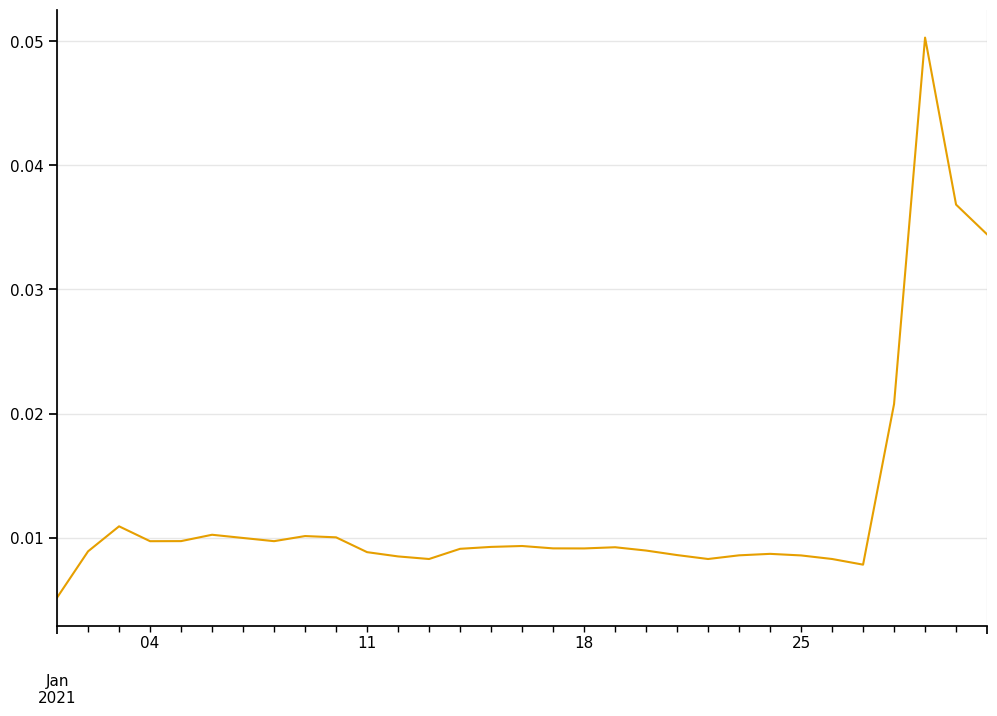

In [112]:
_ = pd.Series(index=future_looking_data.date.values, data=future_looking_data.price.values, name=f'Future {TICKER}').plot()